In [2]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
import itertools
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from typing import List, Union, Any, Tuple, Dict
import time

import warnings
warnings.filterwarnings('ignore')

# Project path
ppath = sys.path[0] + '/../'
sys.path.append(os.path.join(ppath, 'code'))
from discretizers import *

In [15]:
df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
def add_strategies_to_dict(binning_strategies:Dict, strategies:Dict):
    """
    """
    for key in strategies.keys():
        if key in binning_strategies:
            binning_strategies[key].append(strategies[key])
        else: binning_strategies[key] = [strategies[key]]
    return binning_strategies

In [5]:
# Make binning strategies 
#attrs = ['Glucose', 'BMI', 'Age', 'Pregnancies', 'BloodPressure', 'Insulin', 'DiabetesPedigreeFunction', 'SkinThickness']

for bin_length in range(3, 10):
    start_time = time.time()
    attrs = ['Glucose', 'BMI', 'Age']
    target = 'Outcome'
    binning_strategies = {
        'Glucose': [
            np.array([-1, 140, 200]),
            ],
        'BMI': [
            np.array([-1, 18.5, 25, 30, 68]),
            ],
        'Age': [
            np.array([-1, 18, 35, 50, 65, 100]),
            np.array([-1, 25, 40, 55, 75, 100]),
            ],
    }
    gpt_bins = [[-1, 140, 200],[-1, 18.5, 25, 30, 68],[-1, 18, 35, 50, 65, 100],[-1, 25, 40, 55, 75, 100],]
    print("bin length:", bin_length)
    for n_bins in range(2, bin_length):
        df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
        # Equal width
        intervals = equal_width(df, n_bins, attrs)
        binning_strategies = add_strategies_to_dict(binning_strategies, intervals)
        # Equal frequency
        intervals = equal_frequency(df, n_bins, attrs)
        binning_strategies = add_strategies_to_dict(binning_strategies, intervals)
        # ChiMerge
        intervals = chimerge_wrap(df, attrs, target, n_bins)
        binning_strategies = add_strategies_to_dict(binning_strategies, intervals)
        # KMeans
        intervals = KBinsDiscretizer_wrap(df, attrs, n_bins)
        binning_strategies = add_strategies_to_dict(binning_strategies, intervals)

    print("--- %s seconds ---" % (time.time() - start_time))
    #print(binning_strategies)

    strategy_combos = list(itertools.product(*binning_strategies.values()))
    print("number of strategy combinations:", len(strategy_combos))

    start_time = time.time()
    tree_depth = 5
    cols = attrs
    x0 = []
    x1 = []
    x2 = []
    x3 = []
    results = []
    for strategy in strategy_combos:
        # load data
        df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
        # bin fixed columns
        df['DiabetesPedigreeFunction.binned'] = pd.cut(df['DiabetesPedigreeFunction'], bins=[-1, 0.5, 1, 100], labels=[0.5, 1, 100])
        df['DiabetesPedigreeFunction.binned'] = df['DiabetesPedigreeFunction.binned'].astype('float64')
        df['Pregnancies.binned'] = pd.cut(df['Pregnancies'], bins=[-1, 2, 100], labels=[0, 1])
        df['Pregnancies.binned'] = df['Pregnancies.binned'].astype('int64')
        df['Insulin.binned'] = pd.cut(df['Insulin'], bins=[-1, 30, 120, 1000], labels=[30, 120, 1000])
        df['Insulin.binned'] = df['Insulin.binned'].astype('int64')
        df['BloodPressure.binned'] = pd.cut(df['BloodPressure'], bins=[-1, 60, 90, 100, 1000], labels=[60, 90, 100, 1000])
        df['BloodPressure.binned'] = df['BloodPressure.binned'].astype('int64')
        df['SkinThickness.binned'] = pd.cut(df['SkinThickness'], bins=[-1, 20, 40, 60, 80, 100], labels=[20, 40, 60, 80, 100])
        df['SkinThickness.binned'] = df['SkinThickness.binned'].astype('int64')
        # bin variable columns
        gpt_bin_count = 0
        small_bin_count = 0
        for i in range(len(cols)):
            col = cols[i]
            bins = strategy[i]
            df[col + '.binned'] = pd.cut(df[col], bins=bins, labels=bins[1:])
            df[col + '.binned'] = df[col + '.binned'].astype('float64')
            try: 
                if bins in gpt_bins: gpt_bin_count += 1
            except: gpt_bin_count += 0
            if len(bins) <= 6: small_bin_count += 1
        # split data
        df = df.dropna()
        X = df[['Glucose.binned', 'Pregnancies.binned', 'Insulin.binned', 'BMI.binned', 'Age.binned',
                'BloodPressure.binned', 'DiabetesPedigreeFunction.binned', 'SkinThickness.binned']]
        y = df['Outcome']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
        #print(X_train[X_train.isna().any(axis=1)])
        #print(y_train[y_train.isna().any()])
        try: 
            clf = DecisionTreeClassifier(random_state=0,max_depth=tree_depth).fit(X_train, y_train)
            y_pred = clf.predict(X_test)
        except: 
            #print("Error:", sys.exc_info()[0])
            #print(X_train[X_train.isna().any(axis=1)])
            print("Strategy:", strategy)
            #break
        accuracy = accuracy_score(y_test, y_pred)
        #print("Strategy:", strategy)
        #print("Accuracy:", accuracy, "Strategy:", strategy)
        #print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
        #print("Classification report:\n", classification_report(y_test, y_pred))
        row = [accuracy, strategy[0], strategy[1], strategy[2], gpt_bin_count, small_bin_count]
        results.append(row)

    print("Number of results:", len(results))
    results = pd.DataFrame(results, columns=['Accuracy', 'Glucose', 'BMI', 'Age', 'gpt_bin_count', 'small_bin_count'])
    print("--- %s seconds ---" % (time.time() - start_time))

bin length: 3
--- 33.787217140197754 seconds ---
number of strategy combinations: 80
Number of results: 80
--- 1.3825361728668213 seconds ---
bin length: 4
--- 63.58352303504944 seconds ---
number of strategy combinations: 392
Number of results: 392
--- 6.3216471672058105 seconds ---
bin length: 5
--- 93.82874512672424 seconds ---
number of strategy combinations: 1100
Number of results: 1100
--- 17.456395626068115 seconds ---
bin length: 6
--- 126.53325200080872 seconds ---
number of strategy combinations: 2366
Number of results: 2366
--- 37.25276207923889 seconds ---
bin length: 7
--- 156.74845123291016 seconds ---
number of strategy combinations: 4352
Number of results: 4352
--- 68.1824631690979 seconds ---
bin length: 8
--- 187.60166931152344 seconds ---
number of strategy combinations: 7220
Number of results: 7220
--- 112.53233671188354 seconds ---
bin length: 9
--- 218.26047801971436 seconds ---
number of strategy combinations: 11132
Number of results: 11132
--- 194.169095993042 s

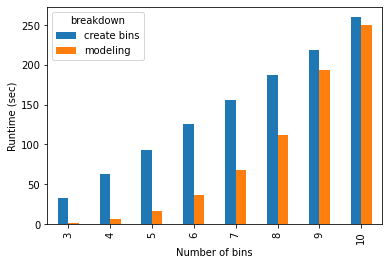

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame([['create bins',3,33],['create bins',4,63],['create bins',5,93],['create bins',6,126],['create bins',7,156],['create bins',8,187],['create bins',9,218],['create bins',10,260],
                   ['modeling',3,1],['modeling',4,6],['modeling',5,17],['modeling',6,37],['modeling',7,68],['modeling',8,112],['modeling',9,194],['modeling',10,250]],
                   columns=['breakdown','Number of bins','val'])

df.pivot("Number of bins", "breakdown", "val").plot(kind='bar')
plt.ylabel('Runtime (sec)')
plt.show()

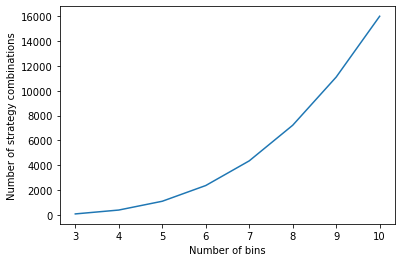

In [14]:
x = [3,4,5,6,7,8,9,10]
y = [80,392, 1100, 2366, 4352, 7220, 11100, 16000]
plt.plot(x, y)
plt.ylabel('Number of strategy combinations')
plt.xlabel('Number of bins')
plt.show()

In [7]:
strategy_combos = list(itertools.product(*binning_strategies.values()))
print("number of strategy combinations:", len(strategy_combos))

number of strategy combinations: 16250


In [9]:
strategy_combos[0]

(array([ -1, 140, 200]),
 array([-1. , 18.5, 25. , 30. , 68. ]),
 array([ -1,  18,  35,  50,  65, 100]))

In [15]:
start_time = time.time()
tree_depth = 5
cols = attrs
x0 = []
x1 = []
x2 = []
x3 = []
results = []
for strategy in strategy_combos:
    # load data
    df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
    # bin fixed columns
    df['DiabetesPedigreeFunction.binned'] = pd.cut(df['DiabetesPedigreeFunction'], bins=[-1, 0.5, 1, 100], labels=[0.5, 1, 100])
    df['DiabetesPedigreeFunction.binned'] = df['DiabetesPedigreeFunction.binned'].astype('float64')
    df['Pregnancies.binned'] = pd.cut(df['Pregnancies'], bins=[-1, 2, 100], labels=[0, 1])
    df['Pregnancies.binned'] = df['Pregnancies.binned'].astype('int64')
    df['Insulin.binned'] = pd.cut(df['Insulin'], bins=[-1, 30, 120, 1000], labels=[30, 120, 1000])
    df['Insulin.binned'] = df['Insulin.binned'].astype('int64')
    df['BloodPressure.binned'] = pd.cut(df['BloodPressure'], bins=[-1, 60, 90, 100, 1000], labels=[60, 90, 100, 1000])
    df['BloodPressure.binned'] = df['BloodPressure.binned'].astype('int64')
    df['SkinThickness.binned'] = pd.cut(df['SkinThickness'], bins=[-1, 20, 40, 60, 80, 100], labels=[20, 40, 60, 80, 100])
    df['SkinThickness.binned'] = df['SkinThickness.binned'].astype('int64')
    # bin variable columns
    gpt_bin_count = 0
    small_bin_count = 0
    for i in range(len(cols)):
        col = cols[i]
        bins = strategy[i]
        df[col + '.binned'] = pd.cut(df[col], bins=bins, labels=bins[1:])
        df[col + '.binned'] = df[col + '.binned'].astype('float64')
        try: 
            if bins in gpt_bins: gpt_bin_count += 1
        except: gpt_bin_count += 0
        if len(bins) <= 6: small_bin_count += 1
    # split data
    df = df.dropna()
    X = df[['Glucose.binned', 'Pregnancies.binned', 'Insulin.binned', 'BMI.binned', 'Age.binned',
            'BloodPressure.binned', 'DiabetesPedigreeFunction.binned', 'SkinThickness.binned']]
    y = df['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    #print(X_train[X_train.isna().any(axis=1)])
    #print(y_train[y_train.isna().any()])
    try: 
        clf = DecisionTreeClassifier(random_state=0,max_depth=tree_depth).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    except: 
        #print("Error:", sys.exc_info()[0])
        #print(X_train[X_train.isna().any(axis=1)])
        print("Strategy:", strategy)
        #break
    accuracy = accuracy_score(y_test, y_pred)
    #print("Strategy:", strategy)
    #print("Accuracy:", accuracy, "Strategy:", strategy)
    #print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    #print("Classification report:\n", classification_report(y_test, y_pred))
    row = [accuracy, strategy[0], strategy[1], strategy[2], gpt_bin_count, small_bin_count]
    results.append(row)

print("Number of results:", len(results))
results = pd.DataFrame(results, columns=['Accuracy', 'Glucose', 'BMI', 'Age', 'gpt_bin_count', 'small_bin_count'])
print("--- %s seconds ---" % (time.time() - start_time))

Error: <class 'ValueError'>
     Glucose.binned  Pregnancies.binned  Insulin.binned  BMI.binned  \
426           140.0                   0              30         NaN   
49            140.0                   1              30         NaN   
522           140.0                   1              30         NaN   
81            140.0                   0              30         NaN   
494           140.0                   1              30         NaN   
60            140.0                   0              30         NaN   
371           140.0                   0             120         NaN   

     Age.binned  BloodPressure.binned  DiabetesPedigreeFunction.binned  \
426        35.0                    60                              0.5   
49         35.0                    60                              0.5   
522        35.0                    60                              0.5   
81         35.0                    60                              0.5   
494        35.0                  

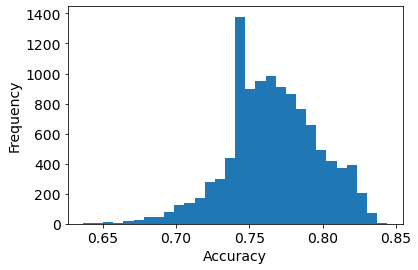

In [19]:
# create a histogram of the accuracy scores
plt.figure()
plt.hist(list(results['Accuracy'].values), bins=30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Accuracy', size=14)
plt.ylabel('Frequency', size=14)
#plt.title('Decision tree accuracy', size=18)
plt.savefig(os.path.join(ppath, 'figs', 'pima-discretizers-histogram.png'), dpi=300, bbox_inches="tight")
plt.show()

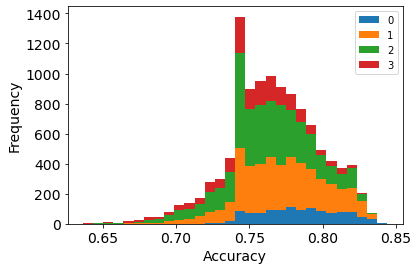

In [56]:
col = 'small_bin_count'
x0 = list(results[(results[col] == 0)]['Accuracy'].values)
x1 = list(results[(results[col] == 1)]['Accuracy'].values)
x2 = list(results[(results[col] == 2)]['Accuracy'].values)
x3 = list(results[(results[col] == 3)]['Accuracy'].values)
# create a histogram of the accuracy scores
plt.figure()
plt.hist([x0, x1, x2, x3], bins=30, stacked=True, label=['0', '1', '2', '3'])
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Accuracy', size=14)
plt.ylabel('Frequency', size=14)
#plt.title('Decision tree accuracy', size=18)
plt.savefig(os.path.join(ppath, 'figs', 'pima-discretizers-bins.png'), dpi=300, bbox_inches="tight")
plt.show()

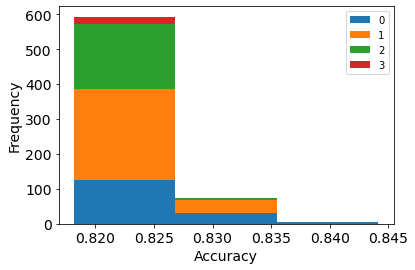

In [57]:
col = 'small_bin_count'
x0 = list(results[(results[col] == 0) & (results['Accuracy'] > 0.818)]['Accuracy'].values)
x1 = list(results[(results[col] == 1) & (results['Accuracy'] > 0.818)]['Accuracy'].values)
x2 = list(results[(results[col] == 2) & (results['Accuracy'] > 0.818)]['Accuracy'].values)
x3 = list(results[(results[col] == 3) & (results['Accuracy'] > 0.818)]['Accuracy'].values)
# create a histogram of the accuracy scores
plt.figure()
plt.hist([x0, x1, x2, x3], bins=3, stacked=True, label=['0', '1', '2', '3'])
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Accuracy', size=14)
plt.ylabel('Frequency', size=14)
#plt.title('Decision tree accuracy', size=18)
plt.savefig(os.path.join(ppath, 'figs', 'pima-discretizers-bins95.png'), dpi=300, bbox_inches="tight")
plt.show()

In [58]:
df = results
df[(df['Accuracy'] > df['Accuracy'].max()-0.02) & df['gpt_bin_count'] > 0]

,Accuracy,Glucose,BMI,Age,gpt_bin_count,small_bin_count
2574,0.824675,"[-inf, 105.0, 130.0, 199.0]","[-inf, 24.288, 27.3, 29.762, 32.0, 34.138, 36....","[-1, 18, 35, 50, 65, 100]",1,2
2626,0.831169,"[-inf, 105.0, 130.0, 199.0]","[-inf, 24.0, 26.5, 28.9, 30.9, 32.9, 34.733, 3...","[-1, 18, 35, 50, 65, 100]",1,2
3114,0.824675,"[-inf, 49.75, 99.5, 149.25, 199.0]","[-1, 18.5, 25, 30, 68]","[-inf, 28.5, 36.0, 43.5, 51.0, 58.5, 66.0, 73....",1,2
3118,0.824675,"[-inf, 49.75, 99.5, 149.25, 199.0]","[-1, 18.5, 25, 30, 68]","[-inf, 22.0, 23.0, 25.0, 28.0, 31.0, 36.0, 42....",1,2
3992,0.824675,"[-inf, 99.0, 127.0, 154.0, 199.0]","[-1, 18.5, 25, 30, 68]","[-inf, 31.0, 41.0, 51.0, 61.0, 71.0, 81.0]",1,2
4316,0.824675,"[-inf, 99.0, 127.0, 154.0, 199.0]","[-inf, 8.388, 25.162, 33.55, 41.938, 50.325, 5...","[-1, 18, 35, 50, 65, 100]",1,2
5318,0.824675,"[-inf, 0.0, 99.0, 127.0, 154.0, 199.0]","[-1, 18.5, 25, 30, 68]","[-inf, 31.0, 41.0, 51.0, 61.0, 71.0, 81.0]",1,2
5320,0.824675,"[-inf, 0.0, 99.0, 127.0, 154.0, 199.0]","[-1, 18.5, 25, 30, 68]","[-inf, 24.0, 30.0, 42.0, 54.0, 62.0, 81.0]",1,2
5321,0.824675,"[-inf, 0.0, 99.0, 127.0, 154.0, 199.0]","[-1, 18.5, 25, 30, 68]","[-inf, 29.571, 38.143, 46.714, 55.286, 63.857,...",1,2
5323,0.824675,"[-inf, 0.0, 99.0, 127.0, 154.0, 199.0]","[-1, 18.5, 25, 30, 68]","[-inf, 24.0, 30.0, 42.0, 54.0, 62.0, 65.0, 81.0]",1,2


In [41]:
df.quantile(.95)

Accuracy           0.818182
gpt_bin_count      1.000000
small_bin_count    3.000000
Name: 0.95, dtype: float64